# **Table of Contents**

- [Get the data]()
- [Import the libraries](#01)
- [Utility Class](#02)
- [Utility Methods](#03)
- [Read the data files](#04)
- [Information about the data - Quick Stats and info](#05)
- [Preprocessing the data](#06)
- [Exploratory data analysis(EDA)](#07)
- [Feature Engineering)](#08)
- [Natural language Processing - Extract features from text)](#09)
- [Clusteting - KMeans](#07)
- [PostProcessing](#11)
- [Final Adjustments](#12)
- [Save the output](#13)



## Get the data

Google collab deletes the data everytime session ends. We will download and save it in a directory which we later can use 

In [ ]:
!curl https://raw.githubusercontent.com/fivethirtyeight/data/master/congress-resignations/congressional_resignations.csv --create-dirs -o ./data/resignation_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57087  100 57087    0     0   357k      0 --:--:-- --:--:-- --:--:--  357k


## Import the libraries

In [ ]:
#Sytem level imports
import os,sys
import string
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

#Data manipulation
import pandas as pd
import numpy as np
from itertools import cycle

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

#Algorithms
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

#NLP imports
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.2.2


## Utility Classes 

In [ ]:
class PreProcessing:
    def __init__(self):
        pass
    
    def fill_nulls(self):
        """
        No nulls in the dataset, we can ignore this for now.
        """
        pass
    

    def change_datatypes(self):
        """
        Change the datatype of the columns which are necessary
        
        Resignation Date : Object -> Date time
        """
        global df
        df["Resignation Date"] = pd.to_datetime(df["Resignation Date"])

In [ ]:
class PostProcesing:
  
    def __init__(self):
      pass

    def define_strength(self):
      global df
      strength_df = df.groupby("Category of Resignation")[feature_name].mean()
      nlargest = 10
      order = np.argsort(-strength_df.values, axis=1)[:, :nlargest]
      result = pd.DataFrame(strength_df.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=strength_df.index)
      print(result)

    def generate_final_dataframe(self,labels):
      global df,feature_name

      df["Category of Resignation"] = "Not Interested"
      m = df['Party'].ne(1) # ne -> not equal to
      df.loc[m, 'Category of Resignation'] = labels

      #Reverting back the change
      df["Congress"] = df["Congress"].astype("str") + "th"
      df["Party"] = df["Party"].map({1:"R",2:"D"})
    
    def final_df_generator(self):
      global df
      
      keep_cols = ["Member","Party","District","Congress","Resignation Date", \
                   "Reason","Source","Category","FirstLast_diff", \
                   "Category of Resignation","Resignation_diff_city"]
      
      df_subset = df[keep_cols]
      save_df_to_csv(df_subset,"output.csv")

In [ ]:
class FeatureEngineering:
    def __init__(self):
        pass
    
    def feature_modification(self):
        global df
    
        df["Congress"] = df["Congress"].map(lambda x: int(str(x)[:-2]))  #Remove "th" and convert the remaining to int
        
        #Change the case of certain categorical columns for homogeneity
        
        for col in ["Member","Party","Reason","Source","Category"]:
            df[col] = df[col].str.lower()

        # Label Encode the Party Column
        df["Party"] = df["Party"].map({"r":1,"d":2})

        df["Category"] = df["Category"].astype("category")
        df["Category_num"] = df["Category"].cat.codes
        

    def feature_addition(self):
        global df

        df["State"] = df["District"].str.split("-").str[0].astype("category")

        # Label Encode the state
        df["State"] = df["State"].cat.codes

        df["Resignation_Month"]  = df["Resignation Date"].dt.month
        df["Resignation_Year"] =  df["Resignation Date"].dt.year  


        """
        Task : 
        
        Question 1 - A new column should be added in the dataset 
        that shows the resignation time difference from the previous 
        resignation in the same district.
        """

        df["Resignation_diff_city"] = df.sort_values("Resignation Date").groupby("District")["Resignation Date"].diff()
        """
        Task :

        Question 3 - New column should be added that shows the time difference 
        of the resignation from the first resignation in that city. 
        """

        df["FirstLast_diff"] = df["Resignation Date"] - df.groupby("District")["Resignation Date"].transform('min')


    def drop_columns(self,colname):
      """
      Here, we will drop certain features which seems redundant/ not so important...
      """
      global df
      if colname in df.columns:
        df.drop([colname],inplace = True, axis = 1)
      else:
        print("Column - {} does not exist in the dataframe")

In [ ]:
class NLP:
  def __init__(self):
    pass

  def stemming_tokens(self,tokens,stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return(stemmed)

  def tokenize(self,text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = self.stemming_tokens(tokens, self.stemmer)
    return(stems)
  
  def clean_and_transformation(self):
    global df 
    
    """
    First, We need to remove punctuations, covert to lowercase, remove stop words, and stem words. 
    All these steps can be directly performed by CountVectorizer.
    We first create a stemmer, using the Porter Stemmer implementation.
    """
    self.stemmer = PorterStemmer()
    self.vectorizer = TfidfVectorizer(analyzer = 'word',
                                 tokenizer = self.tokenize,
                                 lowercase = True,
                                 stop_words = 'english', max_features = 25)
    features = self.vectorizer.fit_transform(df["Reason"].tolist())
    global feature_name 
    feature_name = self.vectorizer.get_feature_names()
    nlp_df = pd.DataFrame(data = features.toarray(),columns = feature_name,index = df.index)
    df = df.join(nlp_df)

In [ ]:
class KMeansAlgorithm:
  # Since 4 category we want to classify into, ["Got Promotion","Joined Private Job","Personal Reasons","Others"] 
  settings = { "n_clusters" : 4,"init" : "k-means++","max_iter" : 300, "n_init" : 10, "random_state" :0}

  def __init__(self):
    pass
  
  def generate_model(self):
    global df

    cls = self.__class__
    self.kmeans = KMeans(**cls.settings) # Initialized model, now get the data ready
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    X = df.loc[df["Party"] == 2].select_dtypes(include=numerics) #Removes every other datatype but those defined in "numerics" 
    X = X[X.columns[~X.isnull().any()]]  # Removes column with nulls
    print(X.shape)
    self.kmeans.fit(X)
    return self.kmeans.labels_
  

In [ ]:
class EDA:
    def __init__(self):
        pass
    
    def frequency_plot(self,colname,top_occur = 5):
        global df
        df[colname].value_counts()[:top_occur].plot(kind = "bar",color = np.random.rand(len(range(top_occur)),3))
    
    def correlation_heatmap(self):
      """
      Quick heatmap of the correlation dataframe to see the strenght of relationship between features
      """
      global df
      corr_df = df.corr()
      if corr_df.empty:
        print("Cannot show correlation, correlation dataframe is empty!!!")
      else:
        sns.heatmap(corr_df)
    
    def resignation_date_hist_plot(self,df_date_column,years_interval):
      
      dates_as_numbers = date2num(df_date_column)
      days_interval = years_interval * 365
      num_bins = round((dates_as_numbers.max() - dates_as_numbers.min()) / days_interval)
      plt.hist(df_date_column, bins=num_bins, ec = 'k')
      plt.gcf().autofmt_xdate()
      plt.xlabel('Year')
      plt.ylabel('Count')
      plt.show()

## Utility methods


The section contains all the different method which will be used in the notebook as a utility

In [ ]:
def df_shape(df):
    """
    Returns the shape of the dataframe
    """
    return df.shape

def get_nulls_info(df):
    """
    Gives the null count for each column
    """
    return df.isnull().sum()


def get_numerical_features(df):
    """
    Returns numerical features for a dataframe
    """
    return df.select_dtypes(include = np.number).columns.tolist()
    
def get_categorical_features(df):
    """
    Returns the categorical feature for a dataframe
    """
    return df.select_dtypes(exclude = np.number).columns.tolist()

def get_correlation(df,corr_type = "pearson"):
    """
    Get the correlation among the features
    """
    return df.corr(method = corr_type)

def distribution_of_features(df):
    """
    Get the distribution of all the features in the dataframe
    """
    column_name = df.columns
    for col in column_name:
        print("Feature - {}\n{}".format(col,df[col].value_counts()))

def save_df_to_csv(df,filename):
    """
    Saves the final dataframe in an output directory as a CSV file.
    If no output directory exists, then it creates it..
    """
    outdir = "./output"
    if not os.path.exists(outdir):
      os.mkdir(outdir)
    fullname = os.path.join(outdir, filename)
    df.to_csv(fullname)

def seperator():
    print('-'*30)

def generate_quick_stats(df):
    
    print("Quick glimpse of the dataframe")
    print(df.head(10))
    seperator()
    print("Shape of the dataframe is - \n{}".format(df_shape(df)))
    seperator()
    print("Nulls in the dataframe are - \n{}".format(get_nulls_info(df)))
    seperator()
    print("Numerical features are - \n{}".format(get_numerical_features(df)))
    seperator()
    print("Categorical features are - \n{}".format(get_categorical_features(df)))
    seperator()
    print("The correlation among the features are -\n{}".format(get_correlation(df,"pearson")))
    seperator()
    print("The distribution of the featues\n{}".format(distribution_of_features(df)))

## Read the data files

In [ ]:
df = pd.read_csv("./data/resignation_data.csv")

## Information about the data - Quick Stats and Info

In [ ]:
 generate_quick_stats(df)

Quick glimpse of the dataframe
           Member Party  ...                    Source Category
0      Pat Tiberi     R  ...            New York Times        D
1      Al Franken     D  ...  Minneapolis Star Tribune        X
2    Trent Franks     R  ...                       CNN        X
3    John Conyers     D  ...           Washington Post        X
4      Tim Murphy     R  ...                  POLITICO        A
5  Jason Chaffetz     R  ...                  POLITICO        D
6      Ryan Zinke     R  ...   Bozeman Daily Chronicle        C
7   Mick Mulvaney     R  ...          Associated Press        C
8       Tom Price     R  ...                GeorgiaPol        C
9   Jeff Sessions     R  ...       Washington Examiner        C

[10 rows x 8 columns]
------------------------------
Shape of the dataframe is - 
(615, 8)
------------------------------
Nulls in the dataframe are - 
Member              0
Party               0
District            0
Congress            0
Resignation Date    0
Re

The data above shows there are no nulls in the dataset and all the columns are Categorical. There is no continuous or discrete numerical data. We don't have to do any imputation of null values in this case.

In the below analysis, we can quickly see how many features are numerical, how many of them are categorical and how many of them are time-series.

Also we can see correlation among the features with the below statistics.

**Analysis** - 

1. Quick distribution shows many Resignations happened between the year [1965 to 1980].
2. Most Resignations happened between [75th and 95th] Congress.
3. Democratic party members gave resignation - 357 times and Repulican party member - 258 times. 
   38% More in Democrats from the Republicans.
4. Atleast 81% of the total resignations happened because the congressmen took other office,private sector,
or resigned early


Good for the first level analysis

---



---



---



We will create objects to access different classes

In [ ]:
# Create the objects of all the Utility Class we are going to use.
prep_obj = PreProcessing()
feat_obj = FeatureEngineering()
eda_obj = EDA()
nlp_obj = NLP()
kmean_obj = KMeansAlgorithm()
postprocess_obj = PostProcesing()

## Preprocessing the data

Now that we had some first level analysis about the data, let's preprocess the data, like filling the NULL values, changing datatype of the columns according to the need.

In [ ]:
prep_obj.fill_nulls()   # Fill the nulls in the dataframe
prep_obj.change_datatypes()  # Change the datatype of the columns required.

We will change certain features from their original format to some other format.
        
**Congress** --> String to Int (example 115th to 115), "th" is redundant here

**Member,Party,Reason, Source,Category** --> Lowercase

In [ ]:
feat_obj.feature_modification()

Till now, we did some preprocessing on the date-time and Categorical column. 
There's still some preprocessing left which we will do later...

## Exploratory data analysis(EDA)

Some distribution plots to see relation of resignation to the party,category, year, congress or district

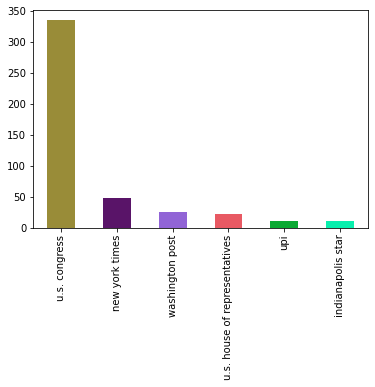

In [ ]:
eda_obj.frequency_plot("Source",6)

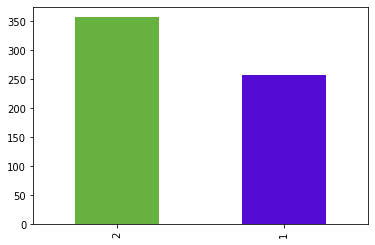

In [ ]:
# Democratic party have had more Resignations between the two..
eda_obj.frequency_plot("Party",5)

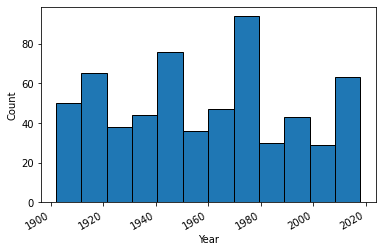

In [ ]:
"""
      Here, we will try to find the number of resignations in X years interval, 
      and see if there is any relation we can find. 
"""
eda_obj.resignation_date_hist_plot(df["Resignation Date"],years_interval = 10)

As can be seen above that during year 1970-1980, there were many resignations

## Feature Engineering

In [ ]:
"""
        This function will do actual feature engineering,
        and will try extracting some more feature from existing features

        1. State from District-> 
            District has format like OH-12, upon searching, I found out that OH is Ohio,
            similarly KY-01, is Kentucky's first congressional district... So we can get the state name from
            the the Districts
        
        2. Year, Month from "Resignation Date"->
            We will try to fetch the Year and Month and later see if that has some significance?
            Day of the month does not make much sense if will be of much use.
"""
feat_obj.feature_addition()

## Natural Language Processing - Extract features from text

In [ ]:
"""
    In this method, we will perform almost all the type of clearning of the 
     only text column in our dataset - "Reason" column, and will convert some numeric column to number for processing
"""
nlp_obj.clean_and_transformation()

## Clustering - KMeans

In [ ]:
# Will generate the KMeans model, feed the features into it and return backs the label for each record.
# We will use the labels(clusters) later to describe the "Category of Resignation"...
labels = kmean_obj.generate_model()

(357, 29)


## PostProcessing

In [ ]:
"""
   Create the "Category of Resignation" feature from the labels and if there "R", we impute "Not Interested"
"""
postprocess_obj.generate_final_dataframe(labels)

In [ ]:
"""
This method is important, it lets you know for each cluster what "KeyWords" were most powerful 
Based on this, we will define the cluster name -> ["Got Promotion","Other","Personal Reasons".. etc]
"""
postprocess_obj.define_strength()

                              top1     top2  ...     top9      top10
Category of Resignation                      ...                    
0                          appoint     judg  ...     took        job
1                        administr  appoint  ...       hi        new
2                           resign    earli  ...  probabl  successor
3                            elect  appoint  ...    senat        new
Not Interested             appoint    elect  ...       hi      earli

[5 rows x 10 columns]


## Final adjustments

In [ ]:
# Convert the previous cluster labels(numeric) to most suitable cateory, based on the strength.
cluster_mapping = {0 : "Got Promotion",2 : "Personal Reasons",1 : "Joined Private Job",3 : "Others","Not Interested":"Not Interested"}

In [ ]:
# Change the mapping in the column
df["Category of Resignation"]  = df["Category of Resignation"].map(cluster_mapping)

## Save the output

In [ ]:
# Generates and save the final dataframe to  ./output/output.csv path
postprocess_obj.final_df_generator()

NameError: ignored